In [12]:
import numpy as np
import random

import matplotlib.pyplot as plt

%matplotlib inline

## 1 Thresholding

+ a. Convert the image to a gray image (5 points).
+ b. Implement a function to threshold the image (20 points) by a threshold value t.
+ c. Plot the ROC curve of that method under varying t (13 points) and submit this as an image file in sufficient quality (2 points).
+ d. What is the optimal threshold t (5 points), if precision and recall are weighted equally?
+ e. Is there a better linear method to convert the RGB into the gray image, so that a sweep results in a better result (5 points)?

### 1.a Convert the image to a gray image

In [16]:
def RGB2Gray(im, weight):
    if weight:
        return 0.299 * im[:, :, 0] + 0.587 * im[:, :, 1] + 0.114 * im[:, :, 2]
    return np.mean(im, axis=2)

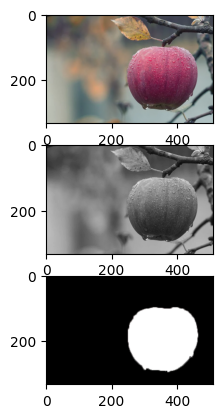

In [17]:
im1 = plt.imread('source.png')
im1_gt = plt.imread('target.png')
height, width, chs = im1.shape
im1_gray = RGB2Gray(im1, False)
# im1_gray1 = np.mean(im1, axis=2)
fig, ax = plt.subplots(3, 1)
ax[0].imshow(im1)
ax[1].imshow(im1_gray, cmap='gray')
ax[2].imshow(im1_gt, cmap='gray')


### 1.b Implement a function to threshold the image by a threshold value t

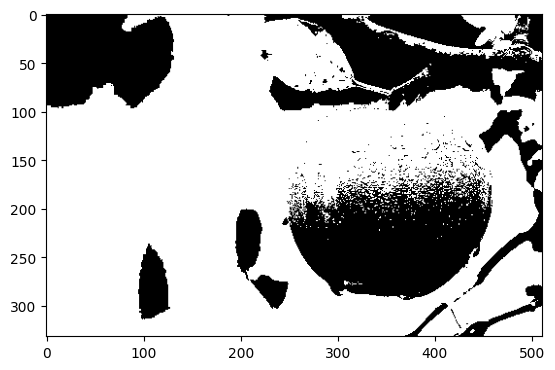

In [18]:
def threshold_image(image_gray, threshold):
    
    height, width = image_gray.shape
    image_gray = image_gray.reshape((height * width))
    thresholded = np.copy(image_gray).reshape((height * width))
    thresholded[image_gray < threshold] = 0
    thresholded[image_gray >= threshold] = 1

    return thresholded.reshape((height, width))
plt.imshow(threshold_image(im1_gray, 0.4), cmap='gray')

### 1.c Plot the ROC curve of that method under varying t

In [46]:
def genROCCurve(image_gray, image_gt):

    assert image_gray.ndim == 2
    if image_gt.ndim == 3:
        image_gt = threshold_image(RGB2Gray(image_gt, False), 0.5)
    assert image_gt.ndim == 2

    height, width = image_gray.shape

    TPR = []
    FPR = []

    t = 100
    for threshold in range(0, t + 1):
        threshold /= 100
        print("Threshold: %f" % threshold)
        # thresholded = threshold_image(image_gray, threshold)
        TP, TN, FP, FN = 0, 0, 0, 0
        for h in range(height):
            for w in range(width):
                if image_gt[h, w] > 0.5:
                    if image_gray[h, w] >= threshold: # 1
                        TP += 1
                    else:
                        FN += 1
                else:
                    if image_gray[h, w] < threshold: # 0
                        TN += 1
                    else:
                        FP += 1
        TPR.append(TP / (TP + FN))
        FPR.append(FP / (FP + TN))

    TPR = np.array(TPR)
    FPR = np.array(FPR)

    plt.figure(figsize=(6, 4))
    plt.plot(FPR, TPR, color='red', linewidth=1)

    return TPR, FPR

Threshold: 0.000000
Threshold: 0.010000
Threshold: 0.020000
Threshold: 0.030000
Threshold: 0.040000
Threshold: 0.050000
Threshold: 0.060000
Threshold: 0.070000
Threshold: 0.080000
Threshold: 0.090000
Threshold: 0.100000
Threshold: 0.110000
Threshold: 0.120000
Threshold: 0.130000
Threshold: 0.140000
Threshold: 0.150000
Threshold: 0.160000
Threshold: 0.170000
Threshold: 0.180000
Threshold: 0.190000
Threshold: 0.200000
Threshold: 0.210000
Threshold: 0.220000
Threshold: 0.230000
Threshold: 0.240000
Threshold: 0.250000
Threshold: 0.260000
Threshold: 0.270000
Threshold: 0.280000
Threshold: 0.290000
Threshold: 0.300000
Threshold: 0.310000
Threshold: 0.320000
Threshold: 0.330000
Threshold: 0.340000
Threshold: 0.350000
Threshold: 0.360000
Threshold: 0.370000
Threshold: 0.380000
Threshold: 0.390000
Threshold: 0.400000
Threshold: 0.410000
Threshold: 0.420000
Threshold: 0.430000
Threshold: 0.440000
Threshold: 0.450000
Threshold: 0.460000
Threshold: 0.470000
Threshold: 0.480000
Threshold: 0.490000


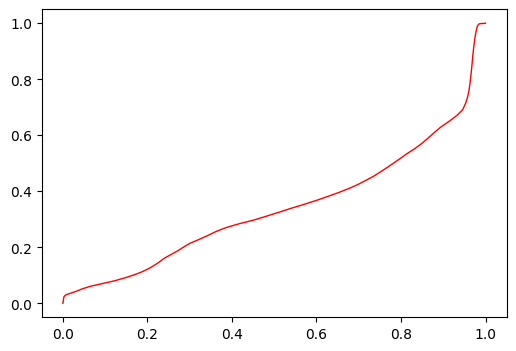

In [47]:
TPR, FPR = genROCCurve(im1_gray, im1_gt)

### 1.d What is the optimal threshold t, if precision and recall are weighted equally?

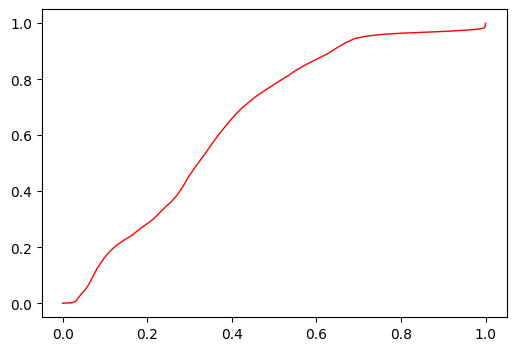

In [48]:
plt.figure(figsize=(6, 4))
plt.plot(TPR, FPR, color='red', linewidth=1)

In [54]:
def findBestThreshold(TPR, FPR):
    n = TPR.shape[0] - 1
    diff = TPR - FPR
    Youden_index = np.argmax(diff)
    return TPR[Youden_index], FPR[Youden_index], Youden_index / n

In [55]:
bTPR, bFPR, bestThreshold = findBestThreshold(FPR, TPR)
print(bTPR, bFPR, bestThreshold)

0.7663668812214102 0.4841697492208662 0.38


### 1.e Is there a better linear method to convert the RGB into the gray image, so that a sweep results in a better result?

Answer:

## 2 Clustering
+ a. Implement a function to segment the image using k-means using only color (25 points) and using color and position (10 points) as features.
+ b. Implement a method to L2-compare the input image and its clustered version, i.e., an image where every pixel is replaced by the mean color of its cluster (10 points). Let is call this the “error”. The algorithms has free parameters: the number of clusters k for k-means <del>and the weight of the Gaussian kernel σ for mean shift</del>. Plot <del>four</del> two error curves for varying k <del>and σ</del> for both the color and color-and-position version of the algorithm (5 points). The horizontal axis is k <del>or σ</del>, the vertical axis is the image error.

In [56]:
im2 = plt.imread('clustering.png')

In [88]:
def kmeans_rgb(I, k, max_it):
    """
    Parameters
    ----------
    I: the image to be segmented (greyscale to begin with) H by W array
    k: the number of clusters (use a simple image with k=2 to begin with)

    Returns
    ----------
    clusters: a vector that contains the final cluster centres
    L: an array the same size as the input image that contains the label for each of the image pixels, according to which cluster it belongs
    """

    assert len(I.shape) == 3, "Wrong input dimensions! Please make sure you are using a RGB image!"

    height, width, c = I.shape
    nData = height * width
    X = I.reshape((nData, c))

    # clusters = np.random.choice(X, size=(k, c), replace=False)
    clusters = np.zeros((k, c))
    clusters_idx = np.random.choice(np.array(range(nData)), size=(1,), replace=False)
    clusters[0] = X[clusters_idx[0]]
    for cc in range(1, k):
        prob = np.zeros((nData,))
        for l in range(cc):
            now_dis = np.linalg.norm(X - clusters[l], axis=1)
            prob = np.max(np.array((now_dis, prob)), axis=0)
        prob /= np.sum(prob)
        clusters_idx = np.random.choice(np.array(range(nData)), size=(1,), replace=False, p=prob)
        clusters[cc] = X[clusters_idx[0]]

    old_clusters = None
    L = np.zeros(shape=(height * width, ))
    it = 0
    while it < max_it:
        print('iter %d' % it)
        old_clusters = clusters.copy()
        dis = np.linalg.norm(X - clusters[0], axis=1)
        for i in range(1, k):
            now_dis = np.linalg.norm(X - clusters[i], axis=1)
            idx = np.where(now_dis < dis)
            dis[idx] = now_dis[idx]
            L[idx] = i
        for i in range(0, k):
            clusters[i] = np.mean(X[np.where(L == i)], axis=0)
        if (old_clusters == clusters).all():
            break
        it += 1
    return clusters, L.reshape((height, width))

iter 0
iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7
iter 8
iter 9
iter 10
iter 11
iter 12
iter 13
iter 14
iter 15
iter 16
iter 17
iter 18
iter 19
iter 20
iter 21
iter 22
iter 23
[[0.57752913 0.46183881 0.33821738 1.        ]
 [0.83941954 0.6485067  0.46287826 1.        ]
 [0.26118559 0.18459477 0.07842766 1.        ]
 [0.4103089  0.38760024 0.15145758 1.        ]]


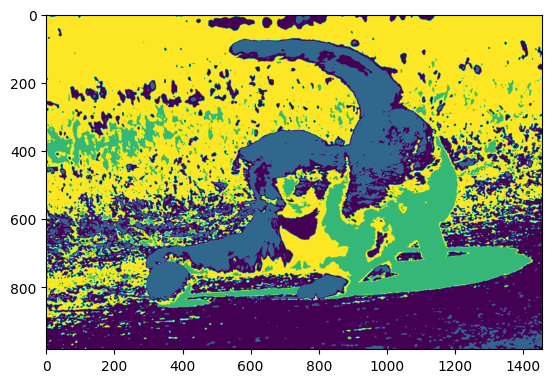

In [89]:
centroids, labels = kmeans_rgb(im2, 4, 100)
plt.imshow(labels)
print(centroids)

In [99]:
def kmeans_rgb_pos(I, k, max_it):
    """
    Parameters
    ----------
    I: the image to be segmented (greyscale to begin with) H by W array
    k: the number of clusters (use a simple image with k=2 to begin with)

    Returns
    ----------
    clusters: a vector that contains the final cluster centres
    L: an array the same size as the input image that contains the label for each of the image pixels, according to which cluster it belongs
    """

    assert len(I.shape) == 3, "Wrong input dimensions! Please make sure you are using a RGB image!"

    height, width, c = I.shape
    pos = np.zeros((height, width, 2))
    for h in range(height):
        for w in range(width):
            pos[h, w] = np.array([h, w])
    I = np.concatenate((I, pos), axis=2)

    height, width, c = I.shape
    nData = height * width
    X = I.reshape((nData, c))

    # clusters = np.random.choice(X, size=(k, c), replace=False)
    clusters = np.zeros((k, c))
    clusters_idx = np.random.choice(np.array(range(nData)), size=(1,), replace=False)
    clusters[0] = X[clusters_idx[0]]
    for cc in range(1, k):
        prob = np.zeros((nData,))
        for l in range(cc):
            now_dis = np.linalg.norm(X - clusters[l], axis=1)
            prob = np.max(np.array((now_dis, prob)), axis=0)
        prob /= np.sum(prob)
        clusters_idx = np.random.choice(np.array(range(nData)), size=(1,), replace=False, p=prob)
        clusters[cc] = X[clusters_idx[0]]

    old_clusters = None
    L = np.zeros(shape=(height * width, ))
    it = 0
    while it < max_it:
        print('iter %d' % it)
        old_clusters = clusters.copy()
        dis = np.linalg.norm(X - clusters[0], axis=1)
        for i in range(1, k):
            now_dis = np.linalg.norm(X - clusters[i], axis=1)
            idx = np.where(now_dis < dis)
            dis[idx] = now_dis[idx]
            L[idx] = i
        for i in range(0, k):
            clusters[i] = np.mean(X[np.where(L == i)], axis=0)
        if (old_clusters == clusters).all():
            break
        it += 1
    return clusters, L.reshape((height, width))

iter 0
iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7
iter 8
iter 9
iter 10
iter 11
iter 12
iter 13
iter 14
iter 15
iter 16
iter 17
iter 18
iter 19
iter 20
iter 21
iter 22
iter 23
iter 24
iter 25
[[4.57271915e-01 4.33819681e-01 1.75957477e-01 1.00000000e+00
  2.21978950e+02 4.09849165e+02]
 [4.83036631e-01 3.60770649e-01 2.73067694e-01 1.00000000e+00
  7.39036807e+02 1.06768455e+03]
 [5.12095891e-01 4.40263099e-01 2.05183267e-01 1.00000000e+00
  2.48942114e+02 1.11807581e+03]
 [5.35563986e-01 4.44366168e-01 2.94579980e-01 1.00000000e+00
  7.03418383e+02 3.26499702e+02]]


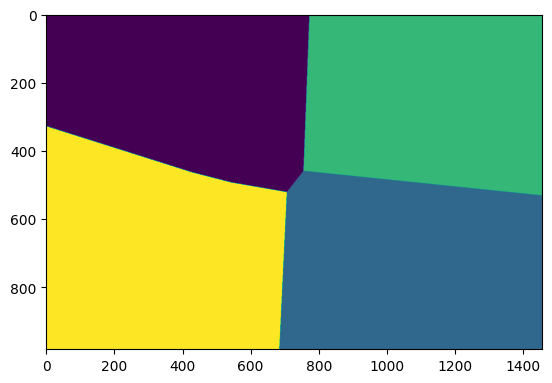

In [104]:
centroids_pos, labels_pos = kmeans_rgb_pos(im2, 4, 100)
plt.imshow(labels_pos)
print(centroids_pos)

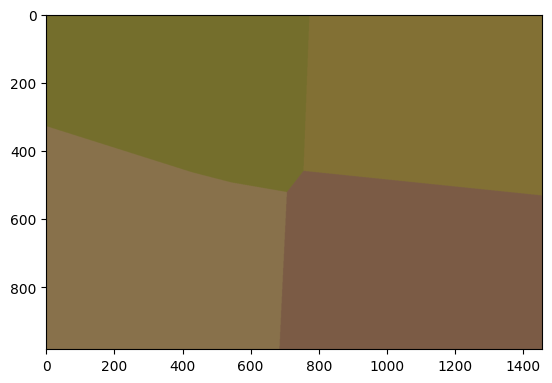

In [121]:
def apply_label_to_img(label, clusters, channels=4):

    height, width = label.shape
    seg_im = np.zeros((height * width, channels))
    label = label.reshape((height * width))
    k = clusters.shape[0]
    for i in range(k):
        pixel = clusters[i, :channels]
        seg_im[label==i] = pixel
    return seg_im.reshape((height, width, channels))

seg_im2 = apply_label_to_img(labels_pos, centroids_pos)
plt.imshow(seg_im2)

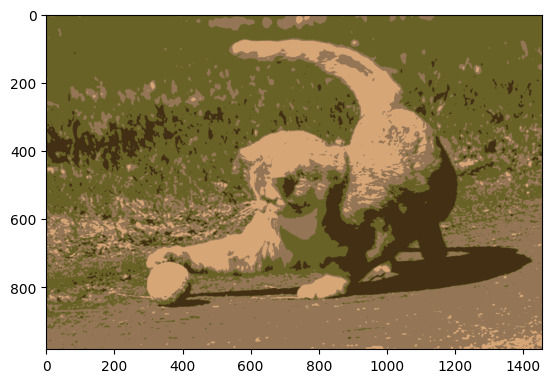

In [122]:
seg_im2_non_pos = apply_label_to_img(labels, centroids)
plt.imshow(seg_im2_non_pos)

### 2.b Implement a method to L2-compare the input image and its clustered version

In [112]:
def l2_compare_img(im1, im2):
    return np.linalg.norm(im1 - im2)

In [113]:
print(l2_compare_img(seg_im2, im2))

302.11737520640037


In [123]:
def image_error_curve(image, kmax):
    l2_error = []
    for k in range(2, kmax + 1):
        centroids, labels = kmeans_rgb(image, k, 100)
        seg_img = apply_label_to_img(labels, centroids)
        l2_error.append(l2_compare_img(seg_img, image))
    plt.figure(figsize=(6, 4))
    plt.plot(range(2, kmax + 1), l2_error, color='red', linewidth=1)

iter 0
iter 1
iter 0
iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7
iter 8
iter 9
iter 10
iter 11
iter 12
iter 13
iter 14
iter 15
iter 16
iter 17
iter 18
iter 19
iter 20
iter 21
iter 22
iter 23
iter 24
iter 25
iter 26
iter 27
iter 28
iter 29
iter 30
iter 31
iter 32
iter 33
iter 34
iter 35
iter 36
iter 37
iter 38
iter 39
iter 40
iter 41
iter 42
iter 43
iter 44
iter 45
iter 46
iter 47
iter 48
iter 49
iter 50
iter 51
iter 52
iter 53
iter 54
iter 55
iter 56
iter 0
iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7
iter 8
iter 9
iter 10
iter 11
iter 12
iter 13
iter 14
iter 15
iter 16
iter 17
iter 18
iter 19
iter 20
iter 21
iter 22
iter 23
iter 24
iter 25
iter 26
iter 27
iter 28
iter 29
iter 30
iter 31
iter 32
iter 33
iter 34
iter 35
iter 36
iter 37
iter 38
iter 39
iter 40
iter 41
iter 42
iter 43
iter 44
iter 45
iter 0
iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7
iter 8
iter 9
iter 10
iter 11
iter 12
iter 13
iter 14
iter 15
iter 16
iter 17
iter 18
iter 19
iter 20
iter 21
iter 22
iter 23


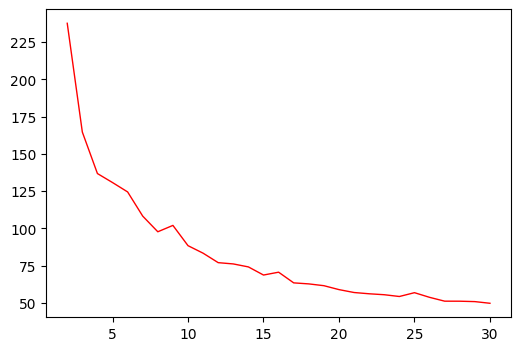

In [125]:
image_error_curve(im2, 30)